# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
import pickle
% matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

**Portfolio data series EDA and pre-processing steps:**

1. Portfolio is a small dataseries with only 10 rows and 6 columns and easy to visualize.

2. Fields 'channels' and 'offer_type' have categorical entries, will use one hot encoding for these fields. Pandas' get_dummy() is used to encode offer_type, but 'channels' field stores lists, so a lambda function is implemented for one hot encoding.

3. Delete the 'channels' field after encoding

4. Rename 'id' field to 'offer_id'



In [3]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
#one hot encoding
offer_cols = pd.get_dummies(portfolio[['offer_type']]) 
portfolio = pd.concat([portfolio, offer_cols], axis=1)

#parse channels list and create individual binary column for each channel
portfolio['web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
portfolio['email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
portfolio['mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
portfolio['social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)

#final cleal up
portfolio.drop(['channels'], inplace=True, axis=1)  
portfolio.rename(columns = {'id':'offer_id'}, inplace = True)
portfolio['duration'] = portfolio['duration']*24
portfolio= portfolio[['offer_id','difficulty', 'duration',  'reward', 'offer_type_bogo',
       'offer_type_discount', 'offer_type_informational', 'web', 'email',
       'mobile', 'social', 'offer_type']]
portfolio


,offer_id,difficulty,duration,reward,offer_type_bogo,offer_type_discount,offer_type_informational,web,email,mobile,social,offer_type
0,ae264e3637204a6fb9bb56bc8210ddfd,10,168,10,1,0,0,0,1,1,1,bogo
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,120,10,1,0,0,1,1,1,1,bogo
2,3f207df678b143eea3cee63160fa8bed,0,96,0,0,0,1,1,1,1,0,informational
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,168,5,1,0,0,1,1,1,0,bogo
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,240,5,0,1,0,1,1,0,0,discount
5,2298d6c36e964ae4a3e7e9706d1fb8c2,7,168,3,0,1,0,1,1,1,1,discount
6,fafdcd668e3743c1bb461111dcafc2a4,10,240,2,0,1,0,1,1,1,1,discount
7,5a8bc65990b245e5a138643cd4eb9837,0,72,0,0,0,1,0,1,1,1,informational
8,f19421c1d4aa40978ebb69ca19b0e20d,5,120,5,1,0,0,1,1,1,1,bogo
9,2906b810c7d4411798c6938adc9daaa5,10,168,2,0,1,0,1,1,1,0,discount


**Profile data series EDA and pre-processing**

*Profile series needs the following data preparation steps*

1. The field 'age' has a maximum entry of 118, which is likely incorrect or a placeholder for NaN
2. Recode 'gender' with Male as 0 and Female as 1, treat 'O' as missing value
3. Calculate the duration of membership by calculating the difference between current date and 'became_member_on' field
4. Rename 'id' field to 'customer_id'

In [5]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [6]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [7]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [8]:
profile['gender'].unique()

array([None, 'F', 'M', 'O'], dtype=object)

In [9]:
#profile clean up
profile['age']=profile['age'].apply(lambda x: np.nan if x== 118 else x )
profile['gender']=profile['gender'].apply(lambda x: None if x=='O' else (0 if x=='M' else 1))
profile['gender'].fillna(2,inplace=True)
profile.dropna(inplace=True)
profile['membership_duration'] = (pd.datetime.now() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d')).dt.days
profile.drop(['became_member_on'], axis=1)
profile=profile.reset_index()
profile.rename(columns = {'id':'customer_id', 'index': 'cus_index'}, inplace = True)
print(profile.describe(), '\n' ,profile.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 7 columns):
cus_index              14825 non-null int64
age                    14825 non-null float64
became_member_on       14825 non-null int64
gender                 14825 non-null float64
customer_id            14825 non-null object
income                 14825 non-null float64
membership_duration    14825 non-null int64
dtypes: float64(3), int64(3), object(1)
memory usage: 810.8+ KB
          cus_index           age  became_member_on        gender  \
count  14825.000000  14825.000000      1.482500e+04  14825.000000   
mean    8496.961079     54.393524      2.016689e+07      0.442024   
std     4896.261043     17.383705      1.188565e+04      0.524650   
min        1.000000     18.000000      2.013073e+07      0.000000   
25%     4273.000000     42.000000      2.016052e+07      0.000000   
50%     8490.000000     55.000000      2.017080e+07      0.000000   
75%    12733.000000     66.000

**Transcript table data preparation**

*Transcript table data preparation is a multi-step process. In this section we will focus on the section that deals with offer related events and leave out any sale transactions for later.*

In the first step we parse the value column and create two new columns to populate the offer id if the event is offer related and the transaction amount if the event is a sale transaction and then drop the value column.

In [10]:
#transcript: parse value table to separate out sale transaction from offer events
transcript['sale_amount']=transcript['value'].apply(lambda x: x['amount'] if 'amount' in x.keys() else None)
transcript['offer_id']=transcript['value'].apply(lambda x: x['offer id'] if 'offer id' in x.keys()                                                 else (x['offer_id'] if 'offer_id' in x.keys() else None))
transcript.drop(['value'], axis=1, inplace=True)
transcript.head()

,event,person,time,sale_amount,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In the next code cell we perform the following tasks
1. Create a new dataframe called 'offers' by only selecting rows from the transcript tables that do not correspond to sale transactions
2. Sort them by customer_if, offer_id and receive time.
3. Assign unique ID called UID for each offer received and merge the view_time and complete_time info to the corresponding UID
4. The resulting table has a UID and corresponding customerif, offer id and receive time, view time and complete time

In [11]:
#create new offers table to hold all offer related records from transcript 
offers=transcript[transcript['event']!="transaction"]
offers=offers.rename(columns = {'person':'customer_id'})
offers=offers.sort_values(by=['customer_id','offer_id','time']) # sort by customer, offer and time so we can assign UID later
offers=offers[['customer_id','offer_id','time','event']]
offers.reset_index(drop=True, inplace=True)

#receive table to hold all offer receipts, create a UID each offer received to merge with other entries
receive=offers[offers['event']=="offer received"]
receive=receive.reset_index(drop=True).reset_index()
receive =receive.rename(columns = {'index':'UID'})

#merge offers ad receive and backfill forward ffill, now all entries have accurate UIDs that can be used for merging
offers=pd.merge(offers, receive, how='left',on=['customer_id', 'offer_id', 'time', 'event'])
offers['UID'].fillna(method='ffill', inplace=True)

#view and complete table created for all UIDs
view=offers[offers['event']=='offer viewed']
view=view.rename(columns = {'time':'view_time'})
complete=offers[offers['event']=='offer completed']
complete=complete.rename(columns = {'time':'complete_time'})
offers=offers.drop(['event'], axis=1)
view = view.drop(['event'], axis=1)
complete = complete.drop(['event'], axis=1)

#offer tables now created by merging  receive, view and complete. UID field ensures correct match
offers=pd.merge(receive, view, how='left',on=['customer_id', 'offer_id', 'UID'])
offers=pd.merge(offers, complete, how='left',on=['customer_id', 'offer_id', 'UID'])
offers=offers.rename(columns = {'time':'receive_time'})
offers.shape[0]

76755

In the next section of the code we merge the the offers table with profile and porrtfolio tables. We will use inner join here, this will result in fewer rows because we have dropped nulls and incorrect values in the profile table. The number of rows dropped from 76755 to 66021.

We also add columns to identify is an offer is viewed and if an offer is completed

In [12]:
#merge offers table with profile and then with portfolio
offers=pd.merge(offers, profile, how='inner',on=['customer_id'])
offers=pd.merge(offers, portfolio, how='left',on=['offer_id'])
offers['expire_time']=offers['receive_time'] + offers['duration'] # expire time to know when an offer expires



offers['viewed'] = offers.apply(
    lambda row: 0 if (np.isnan(row['view_time'])) or 
                      ((np.isnan(row['complete_time']) ==False) and (row['view_time']> row['complete_time'])) else 1,
    axis=1
)

offers['completed'] = offers.apply(
    lambda row: 1 if ((row['viewed']==1) and (np.isnan(row['complete_time'])==False)) else 0,
    axis=1
)

offers['end_time'] = offers.apply(
    lambda row: row['complete_time'] if row['completed'] ==1 else (row['expire_time'] if row['expire_time']<=714 else 714) ,
    axis=1
)

offers.loc[(offers['view_time']>offers['expire_time']) & (offers['viewed']==1), 'viewed'] =0
offers.shape[0]

66945

# Data Visualization

We will start be reviewing historgrams of all the features in the dataset in the first phase of data visualization to understand the data better. We will perform the second phase on visualizations after reviewing the weights of our baseline model.

Text(0,0.5,'Frequency')

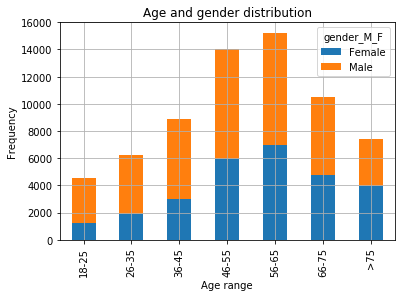

In [13]:
#Add age_range field
offers['age_range']='18-25'
offers.loc[(offers['age']>25) & (offers['age']<=35),'age_range']= '26-35'
offers.loc[(offers['age']>35) & (offers['age']<=45), 'age_range']= '36-45'
offers.loc[(offers['age']>45) & (offers['age']<=55), 'age_range']= '46-55'
offers.loc[(offers['age']>55) & (offers['age']<=65), 'age_range']= '56-65'
offers.loc[(offers['age']>65) & (offers['age']<=75),'age_range']= '66-75'
offers.loc[offers['age']>75, 'age_range']= '>75'

#Add gender_M_F field
offers['gender_M_F'] = 'Male'
offers.loc[offers['gender']==1,'gender_M_F' ]= 'Female'

#plot bar chart of age range distribution bar chart with gender stacked on top
ax=offers.groupby(['age_range','gender_M_F']).size().unstack().plot(kind='bar',stacked=True, grid=True, 
                                                                 title='Age and gender distribution')
ax.set_xlabel("Age range")
ax.set_ylabel("Frequency")



In [14]:
profile.income.min()

30000.0

Text(0.5,0,'Income in USD')

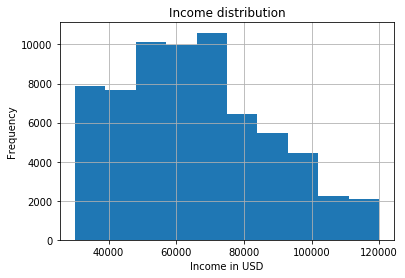

In [15]:
#ax=offers.hist('income')
ax=offers['income'].plot(kind='hist', grid=True, title ='Income distribution')
ax.set_xlabel('Income in USD')

Text(0.5,0,'Membership duration in days')

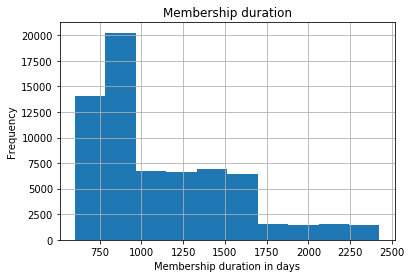

In [16]:
ax=offers['membership_duration'].plot(kind='hist', grid=True, title ='Membership duration')
ax.set_xlabel('Membership duration in days')

Text(0,0.5,'Frequency')

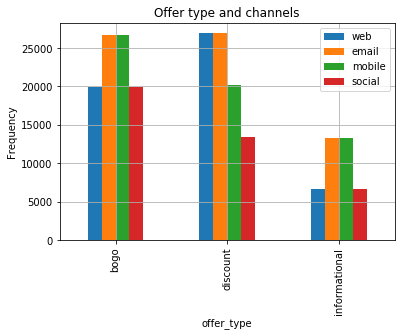

In [17]:
ax=offers.groupby(['offer_type']).agg({'web': 'sum', 'email': 'sum', 'mobile':'sum', 
                                       'social':'sum'}).plot(kind='bar', grid=True, title='Offer type and channels')
ax.set_ylabel('Frequency')


**Should we include type of offer to predict if an offer will be viewed?**

Here we make an assumption that the customer does not know the type of offer until it they view it. Therefore this model does not take into account the type of offer type for predicting whether or not an offer will be viewed, but considers all other features like the demographics and the promotional channels used to advertise etc. 

Plot below shows the view rate by the offer type and there is not a vast difference in the view rates based on the offer type, so we will stick with the assumption.

Text(0,0.5,'View rate')

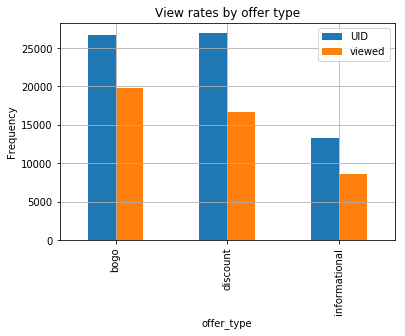

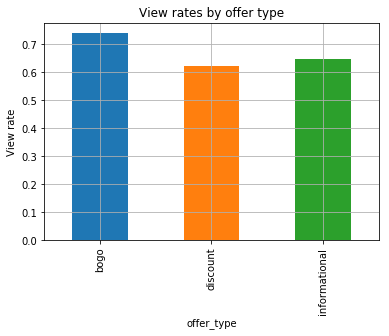

In [18]:
offers_views= offers.groupby(['offer_type']).agg({ 'UID':'count','viewed': 'sum'})
offers_views['view_rate']= offers_views['viewed']/offers_views['UID']
ax0=offers_views[['UID','viewed']].plot(kind='bar', grid=True, title='View rates by offer type')
ax0.set_ylabel('Frequency')
plt.figure()
ax1=offers_views['view_rate'].plot(kind='bar', grid=True, title='View rates by offer type')
ax1.set_ylabel('View rate')

**Data preparation - phase 2**

The this step we prepare the sale transaction data

In [19]:
sales=transcript[transcript['event']=='transaction']
sales=sales.reset_index(drop=True).reset_index()
sales=sales.drop(['offer_id'],axis=1)
sales=sales.rename(columns={'index':'sale_id', 'person':'customer_id', 'time':'sale_time'})
sales=pd.merge(offers[['UID','view_time', 'end_time', 'offer_id', 'customer_id', 'viewed']], 
               sales, how='left', on=['customer_id'])
sales.shape[0]

574810

We now plot the sale amount for each customer ID. We also plot summary stats (min, max and mean) sale for each customer.
We notice that 359 customers have made one time transaction >$200.

No. of customer who made sale transactions> $200 =  363


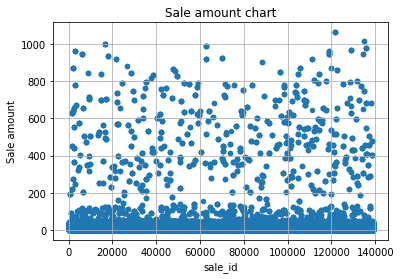

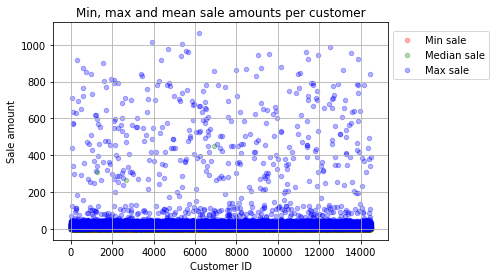

In [20]:
ax=sales.plot(x='sale_id', y='sale_amount', kind='scatter', title ='Sale amount chart', grid=True)
ax.set_ylabel('Sale amount')
sales_groupby=sales.groupby(['customer_id']).agg({'sale_amount': ['max', 'min', 'median']})
sales_groupby.dropna(axis=0, inplace=True)
sales_groupby.reset_index(inplace=True, drop=True)
sales_groupby.reset_index(inplace=True)
sales_groupby.columns=['cust_id','max_sale','min_sale','median_sale']
sales_groupby.head()
ax1 = sales_groupby.plot(kind='scatter', x='cust_id', y='min_sale', color='r',grid=True, alpha=0.3, label='Min sale')    
ax2 = sales_groupby.plot(kind='scatter', x='cust_id', y='median_sale', color='g', ax=ax1,grid=True, alpha=0.3, label='Median sale')    
ax3 = sales_groupby.plot(kind='scatter', x='cust_id', y='max_sale', color='b', ax=ax1, alpha=0.3,grid=True, label='Max sale')
ax1.set_ylabel('Sale amount')
ax1.set_xlabel('Customer ID')
ax1.set_title('Min, max and mean sale amounts per customer')
ax1.legend(loc='center left', bbox_to_anchor=(1.0, 0.85))
print('No. of customer who made sale transactions> $200 = ',sales_groupby[sales_groupby['max_sale']>200].shape[0])

In [21]:
sales['UID_sale']=(sales['view_time']  <= sales['sale_time'] ) & (sales['sale_time'] 
                                                                    <=sales['end_time']) & (sales['viewed']==1)
offer_metrics=sales[['sale_id', 'sale_amount', 'customer_id']]
offer_metrics=offer_metrics.drop_duplicates()
offer_sale_id =pd.DataFrame(sales.loc[sales['UID_sale']==True, 'sale_id'], columns=['sale_id'])
offer_sale_id =offer_sale_id.drop_duplicates()
offer_sale_id ['type']='offer'
offer_metrics=pd.merge(offer_metrics, offer_sale_id, how='left', on='sale_id')
offer_metrics['type'].fillna('nonoffer', inplace = True)
offer_metrics.head()

,sale_id,sale_amount,customer_id,type
0,37632.0,22.16,0009655768c64bdeb2e877511632db8f,offer
1,71464.0,8.57,0009655768c64bdeb2e877511632db8f,offer
2,97672.0,14.11,0009655768c64bdeb2e877511632db8f,nonoffer
3,103292.0,13.56,0009655768c64bdeb2e877511632db8f,nonoffer
4,108756.0,10.27,0009655768c64bdeb2e877511632db8f,nonoffer


In [22]:
offer_metrics_groupby=offer_metrics.groupby(['customer_id','type']).agg({'sale_amount': ['max', 'sum', 'median','count']})
offer_metrics_groupby=offer_metrics_groupby.reset_index()
offer_metrics_groupby.columns=['customer_id','type','max','sum','median','n']
metrics=pd.merge(offer_metrics_groupby[offer_metrics_groupby['type']=='offer'],offer_metrics_groupby[offer_metrics_groupby['type']=='nonoffer'],
                how='outer', on=['customer_id'])
metrics=metrics.drop(['type_x','type_y'], axis=1)
metrics.columns=['customer_id', 'max_offer','sum_offer', 'median_offer', 'n_offer_tran',
                 'max_nonoffer','sum_nonoffer', 'median_nonoffer', 'n_nonoffer_tran']
metrics=metrics.fillna(0)
metrics.head()

,customer_id,max_offer,sum_offer,median_offer,n_offer_tran,max_nonoffer,sum_nonoffer,median_nonoffer,n_nonoffer_tran
0,0009655768c64bdeb2e877511632db8f,22.16,30.73,15.365,2.0,28.16,96.87,13.835,6.0
1,0011e0d4e6b944f998e987f904e8c1e5,22.05,33.98,16.990,2.0,23.03,45.48,13.490,3.0
2,0020c2b971eb4e9188eac86d93036a77,17.63,34.87,17.435,2.0,33.86,161.99,26.165,6.0
3,0020ccbbb6d84e358d3414a3ff76cffd,20.08,95.37,11.650,7.0,16.27,58.68,13.860,5.0
4,003d66b6608740288d6cc97a6903f4f0,5.94,30.92,2.240,12.0,7.41,17.42,2.295,6.0


For each customer, we find the historic view and completion rate. For completion rate calculations we exclude informational only offers, as these offers cannot be completed.

In [23]:
cus_history=offers[['customer_id','completed','UID','viewed', 'offer_type_informational']]
cus_history=cus_history.groupby(['customer_id']).agg({'completed':'sum', 'offer_type_informational':'sum',
                                                     'viewed':'sum','UID':'count'})
cus_history.reset_index(inplace=True)
cus_history.columns=['customer_id','total_completed','informational_offers','total_viewed','total_offers' ]
cus_history['comp_rate']=cus_history['total_completed']/(cus_history['total_offers'] -cus_history['informational_offers'])
cus_history['view_rate']=cus_history['total_viewed']/cus_history['total_offers']
cus_history = cus_history.iloc[:,[0,5,6]]
cus_history.head()
#cus_history[cus_history.isna().any(axis=1)]

,customer_id,comp_rate,view_rate
0,0009655768c64bdeb2e877511632db8f,0.000000,0.4
1,0011e0d4e6b944f998e987f904e8c1e5,1.000000,1.0
2,0020c2b971eb4e9188eac86d93036a77,0.500000,0.4
3,0020ccbbb6d84e358d3414a3ff76cffd,1.000000,1.0
4,003d66b6608740288d6cc97a6903f4f0,0.666667,0.8


We then calculate metrics such as tototal time there was an offer and total time there was no offer for a given customers and the sale transactions during these times.

In [24]:
metrics_time=sales.loc[sales['viewed']==1,['customer_id','view_time','end_time']]
metrics_time['offer_hours'] = metrics_time.apply(
    lambda row: (np.arange(row['view_time'], (row['end_time']+1))).tolist(),
    axis=1
)
metrics_time=metrics_time.drop(['view_time','end_time'],axis=1)
metrics_time = metrics_time.groupby(['customer_id'])['offer_hours'].sum()
metrics_time = pd.DataFrame(metrics_time).reset_index()
metrics_time['total_offer_hours'] = metrics_time.apply(lambda row: len(np.unique(np.array(row['offer_hours']))),axis=1)
metrics_time=metrics_time.drop(['offer_hours'], axis=1)
metrics_time['total_nonoffer_hours']= 714-metrics_time['total_offer_hours']
metrics_time.head()

,customer_id,total_offer_hours,total_nonoffer_hours
0,0009655768c64bdeb2e877511632db8f,110,604
1,0011e0d4e6b944f998e987f904e8c1e5,358,356
2,0020c2b971eb4e9188eac86d93036a77,128,586
3,0020ccbbb6d84e358d3414a3ff76cffd,178,536
4,003d66b6608740288d6cc97a6903f4f0,242,472


In [25]:
metrics_final=pd.merge(metrics_time, metrics, how='left', on=['customer_id']).fillna(0)
metrics_final.head()
metrics_final['avg_offer_sale']=metrics_final['sum_offer']/metrics_final['total_offer_hours']
metrics_final['avg_nonoffer_sale']=metrics_final['sum_nonoffer']/metrics_final['total_nonoffer_hours']
metrics_final['avg_offer_tran']=metrics_final['n_offer_tran']/metrics_final['total_offer_hours']
metrics_final['avg_nonoffer_tran']=metrics_final['n_nonoffer_tran']/metrics_final['total_nonoffer_hours']
metrics_final.drop(['sum_offer','sum_nonoffer','n_offer_tran','n_nonoffer_tran','total_offer_hours','total_nonoffer_hours'], 
                   axis=1, inplace=True)
metrics_final.head()

,customer_id,max_offer,median_offer,max_nonoffer,median_nonoffer,avg_offer_sale,avg_nonoffer_sale,avg_offer_tran,avg_nonoffer_tran
0,0009655768c64bdeb2e877511632db8f,22.16,15.365,28.16,13.835,0.279364,0.160381,0.018182,0.009934
1,0011e0d4e6b944f998e987f904e8c1e5,22.05,16.990,23.03,13.490,0.094916,0.127753,0.005587,0.008427
2,0020c2b971eb4e9188eac86d93036a77,17.63,17.435,33.86,26.165,0.272422,0.276433,0.015625,0.010239
3,0020ccbbb6d84e358d3414a3ff76cffd,20.08,11.650,16.27,13.860,0.535787,0.109478,0.039326,0.009328
4,003d66b6608740288d6cc97a6903f4f0,5.94,2.240,7.41,2.295,0.127769,0.036907,0.049587,0.012712


We then create two more tables to record sales that occurred when there was an active offer and when there was no active offer.

In [26]:
UID_sales=sales.loc[sales['UID_sale']==True, ['UID','sale_id', 'sale_amount']]
offer_metrics=sales[['sale_id', 'UID_sale','sale_amount', 'customer_id']]
metric_subset =sales.loc[sales['UID_sale']==True, 'sale_id']

#UID_sales records sales that occur when an offer is present
UID_sales=UID_sales.drop_duplicates().reset_index(drop=True)
UID_sales=UID_sales.drop(['sale_id'], axis=1)
UID_sales = pd.DataFrame(UID_sales.groupby(['UID'])['sale_amount'].sum())
UID_sales.reset_index(level=0, inplace=True)
UID_sales.columns=['UID','Total_UID_Sale']
UID_sales.head()

,UID,Total_UID_Sale
0,1,8.57
1,2,22.16
2,7,22.05
3,8,11.93
4,11,22.05


We then find the duration where an offer is active and the total duration where a customer does not have any open offers

In [27]:
#Create the final dataframe that includes average sale for periods with and without active offers
Final_df=pd.merge(offers,UID_sales, how='left', on=['UID'] )

Final_df['Total_UID_Sale'].fillna(0, inplace=True)                     
Final_df['Average_UID_sale'] =Final_df['Total_UID_Sale']/(Final_df['end_time'] - Final_df['view_time'])
Final_df.loc[Final_df['end_time'] == Final_df['view_time'], ['Average_UID_sale']]=Final_df['Total_UID_Sale']
Final_df['Average_UID_sale']=Final_df['Average_UID_sale'].fillna(0)

Final_df=pd.merge(Final_df, metrics_final, how='inner', on=['customer_id'])
Final_df=pd.merge(Final_df,cus_history, how='left', on=['customer_id'] )
Final_df['comp_rate'].fillna(0, inplace=True)   
Final_df['view_rate'].fillna(0, inplace=True)

#We define gain ratio as teh ratio between average sale when there is an offer to the average sale when there is no offer
Final_df['gain_ratio']=(Final_df['Average_UID_sale']-Final_df['avg_nonoffer_sale'])/Final_df['avg_nonoffer_sale']
Final_df['gain_ratio'].fillna(0, inplace=True)
Final_df.columns



Index(['UID', 'customer_id', 'offer_id', 'receive_time', 'event', 'view_time',
       'complete_time', 'cus_index', 'age', 'became_member_on', 'gender',
       'income', 'membership_duration', 'difficulty', 'duration', 'reward',
       'offer_type_bogo', 'offer_type_discount', 'offer_type_informational',
       'web', 'email', 'mobile', 'social', 'offer_type', 'expire_time',
       'viewed', 'completed', 'end_time', 'age_range', 'gender_M_F',
       'Total_UID_Sale', 'Average_UID_sale', 'max_offer', 'median_offer',
       'max_nonoffer', 'median_nonoffer', 'avg_offer_sale',
       'avg_nonoffer_sale', 'avg_offer_tran', 'avg_nonoffer_tran', 'comp_rate',
       'view_rate', 'gain_ratio'],
      dtype='object')

In [28]:
# Discard entries where average nonoffer sale is too low, this will artifically inflate gain ratios
Final_df=Final_df.loc[Final_df['avg_nonoffer_sale']>=1/48,:] 

#Define outcome a category variable based on sales increase
Final_df['Outcome']=0
Final_df.loc[(Final_df['gain_ratio']>=1.0) & (Final_df['gain_ratio']<1.1),['Outcome']]=1
Final_df.loc[(Final_df['gain_ratio']>=1.1) & (Final_df['gain_ratio']<1.25),['Outcome']]=2
Final_df.loc[(Final_df['gain_ratio']>=1.25) & (Final_df['gain_ratio']<2),['Outcome']]=3
Final_df.loc[Final_df['gain_ratio']>=2,['Outcome']]=4
Final_df = Final_df.sample(frac=1, random_state=42)
Final_df.columns

Index(['UID', 'customer_id', 'offer_id', 'receive_time', 'event', 'view_time',
       'complete_time', 'cus_index', 'age', 'became_member_on', 'gender',
       'income', 'membership_duration', 'difficulty', 'duration', 'reward',
       'offer_type_bogo', 'offer_type_discount', 'offer_type_informational',
       'web', 'email', 'mobile', 'social', 'offer_type', 'expire_time',
       'viewed', 'completed', 'end_time', 'age_range', 'gender_M_F',
       'Total_UID_Sale', 'Average_UID_sale', 'max_offer', 'median_offer',
       'max_nonoffer', 'median_nonoffer', 'avg_offer_sale',
       'avg_nonoffer_sale', 'avg_offer_tran', 'avg_nonoffer_tran', 'comp_rate',
       'view_rate', 'gain_ratio', 'Outcome'],
      dtype='object')

In [29]:
#Generate X and y tables for outcome prediction 
view_model=Final_df
outcome_model=Final_df[Final_df['viewed']==1]
complete_model=outcome_model[outcome_model['offer_type_informational']==0]

y_view=view_model['viewed']
y_outcome=outcome_model['Outcome']
y_complete=complete_model['completed']

# Modeling data to predict if an offer will be viewed

In [30]:
X_view = view_model[['age', 'gender','income', 'membership_duration', 'web', 'email', 'mobile', 'social', 'expire_time',
                    'max_offer', 'median_offer','max_nonoffer','median_nonoffer','avg_offer_sale', 
                    'avg_nonoffer_sale','avg_offer_tran','comp_rate', 'view_rate']]
scaler = MinMaxScaler(feature_range=(0,1))
X_view = pd.DataFrame(scaler.fit_transform(X_view), columns=['age', 'gender','income', 'membership_duration', 'web', 'email', 
                                                             'mobile', 'social', 
                                                             'expire_time', 'max_offer', 'median_offer',
                                                             'max_nonoffer','median_nonoffer','avg_offer_sale', 
                                                             'avg_nonoffer_sale','avg_offer_tran','comp_rate', 'view_rate'])

In [31]:
#Perform test train splits
X_train_view, X_test_view, y_train_view, y_test_view = train_test_split(X_view, y_view, test_size=0.33, random_state=42)

# Fit baseline model, predict test data and compute metric
LG_view = LogisticRegression(random_state=0, class_weight='balanced')
LG_view.fit(X_train_view, y_train_view)
y_pred_view=LG_view.predict(X_test_view)
f1_view=f1_score(y_pred_view, y_test_view)
print('F1 score for the baseline view model = ', f1_view)

F1 score for the baseline view model =  0.835781527127


In [32]:
#Create a dataframe of logistic regression weights
weights =pd.DataFrame(LG_view.coef_ .T, columns=['view_weights'])
values =pd.DataFrame(X_test_view.columns, columns=['values'])
weight_values=pd.concat([values, weights],axis=1).sort_values(by=['view_weights']).reset_index(drop=True)
weight_values

,values,view_weights
0,avg_nonoffer_sale,-1.862540
1,expire_time,-0.669228
2,median_nonoffer,-0.457174
3,max_offer,-0.161893
4,income,-0.040568
5,membership_duration,-0.018083
6,avg_offer_sale,-0.000682
7,email,0.000000
8,gender,0.006147
9,age,0.023639


Model shows that the strongest predictor for view is the historic view rates of the customer. The baseline F1 score is pretty good at 0.85.

We now try the following three models and compare their F1 score against the baseline model and select the best model

Random Forest classifier
K Neighbors classifier
Naïve Bayes classifier

In [33]:
#RandomForest
from sklearn.ensemble import RandomForestClassifier
RFC_view = RandomForestClassifier(class_weight='balanced', random_state = 42)
RFC_view.fit(X_train_view, y_train_view) 
y_pred_view= RFC_view.predict(X_test_view)
RFC_view_f1=f1_score(y_pred_view, y_test_view)
print(RFC_view_f1)

0.837321605657


In [34]:
#KNeighbors
from sklearn.neighbors import KNeighborsClassifier
KNC_view=KNeighborsClassifier()
KNC_view.fit(X_train_view, y_train_view) 
y_pred_view= KNC_view.predict(X_test_view)
KNC_view_f1=f1_score(y_pred_view, y_test_view)
print(KNC_view_f1)


0.852436688657


In [35]:
# Naive Bayes classifier
NBC_view = GaussianNB()
NBC_view.fit(X_train_view, y_train_view) 
y_pred_view= NBC_view.predict(X_test_view)
NBC_view_f1=f1_score(y_pred_view, y_test_view)
print(NBC_view_f1)

0.834055171876


KNN classifer has the highest F1 score. We will not perform some hyperparameter tuning using GridSearchCV to see if we can improve this score.

In [36]:
#Hyperparameters to tune
leaf_size = [20,25,30,35,40,45,50]
n_neighbors = list(range(2,20))
p=[1,2]

hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

#Create new KNN object
knn_hpt = KNeighborsClassifier()
#Use GridSearch

X_val=X_test_view.reset_index(drop=True)
X_val=X_val.iloc[0:1000,:]
y_val=y_test_view.reset_index(drop=True)
y_val=y_val[0:1000]

clf = GridSearchCV(knn_hpt, hyperparameters, cv=10, scoring ='f1_weighted')
#Fit the model
best_model = clf.fit(X_val, y_val)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best leaf_size: 20
Best p: 2
Best n_neighbors: 17


In [37]:
#KNC model with the best hyperparameters
KNC_view=KNeighborsClassifier(leaf_size=20,p=1,n_neighbors=19)
KNC_view.fit(X_train_view, y_train_view) 
y_pred_view= KNC_view.predict(X_test_view)
KNC_view_f1=f1_score(y_pred_view, y_test_view)
print(KNC_view_f1)

0.871268891029


The hyperparameter tuning has marginally increased the F1 score from 0.86 to 0.88. We now have a good model to predict the view rates of the offer.We now save this model to a pickle file for future use.

In [38]:
import pickle
filename = 'view_model.sav'
pickle.dump(KNC_view, open(filename, 'wb'))

# Model for predicting if an offer will becompleted

In [39]:
X_complete = complete_model[['age', 'gender','income', 'membership_duration', 'web', 'email', 'mobile', 'social', 'expire_time',
                    'max_offer', 'median_offer','max_nonoffer','median_nonoffer','avg_offer_sale', 
                    'avg_nonoffer_sale','avg_offer_tran','comp_rate', 'view_rate']]
X_complete = pd.DataFrame(scaler.fit_transform(X_complete), columns=['age', 'gender','income', 'membership_duration', 'web', 'email', 
                                                             'mobile', 'social', 
                                                             'expire_time', 'max_offer', 'median_offer',
                                                             'max_nonoffer','median_nonoffer','avg_offer_sale', 
                                                             'avg_nonoffer_sale','avg_offer_tran','comp_rate', 'view_rate'])
#Perform test train splits
X_train_complete, X_test_complete, y_train_complete, y_test_complete = train_test_split(X_complete, y_complete, 
                                                                                        test_size=0.33, random_state=42)

In [40]:
# Fit baseline model, predict test data and compute metric
LG_complete = LogisticRegression(random_state=0, class_weight='balanced')
LG_complete.fit(X_train_complete, y_train_complete)
y_pred_complete=LG_complete.predict(X_test_complete)
f1_complete=f1_score(y_pred_complete, y_test_complete)
print('F1 score for the baseline complete model = ', f1_complete)

F1 score for the baseline complete model =  0.894976475945


In [41]:
#Create a dataframe of logistic regression weights
weights =pd.DataFrame(LG_complete.coef_ .T, columns=['complete_weights'])
values =pd.DataFrame(X_test_complete.columns, columns=['values'])
weight_values=pd.concat([values, weights],axis=1).sort_values(by=['complete_weights']).reset_index(drop=True)
weight_values

,values,complete_weights
0,view_rate,-5.383915
1,max_nonoffer,-1.336850
2,membership_duration,-0.112429
3,social,-0.098800
4,email,0.000000
5,age,0.032722
6,income,0.050325
7,max_offer,0.053184
8,gender,0.074665
9,avg_offer_sale,0.226321


The baseline model has an F1 score of 0.89. We will now fit the three other model as in the previous exercise.

In [42]:
#RandomForest
from sklearn.ensemble import RandomForestClassifier
RFC_complete = RandomForestClassifier(class_weight='balanced', random_state = 42)
RFC_complete.fit(X_train_complete, y_train_complete) 
y_pred_complete= RFC_complete.predict(X_test_complete)
RFC_complete_f1=f1_score(y_pred_complete, y_test_complete)
print(RFC_complete_f1)

0.869156852829


In [43]:
#KNeighbors
from sklearn.neighbors import KNeighborsClassifier
KNC_complete=KNeighborsClassifier()
KNC_complete.fit(X_train_complete, y_train_complete) 
y_pred_complete= KNC_complete.predict(X_test_complete)
KNC_complete_f1=f1_score(y_pred_complete, y_test_complete)
print(KNC_complete_f1)

0.900576571509


In [44]:
# Naive Bayes classifier
from sklearn.naive_bayes import GaussianNB
NBC_complete = GaussianNB()
NBC_complete.fit(X_train_complete, y_train_complete) 
y_pred_complete= NBC_complete.predict(X_test_complete)
NBC_complete_f1=f1_score(y_pred_complete, y_test_complete)
print(NBC_complete_f1)

0.568167669641


We will now perform hyperparemeter tuning on KNN classifer which has the highest F1 scores of all the models tested

In [45]:
#Hyperparameters to tune
leaf_size = list(range(40,50))
n_neighbors = list(range(2,20))
p=[1,2]

hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

#Create new KNN object
knn_hpt = KNeighborsClassifier()
#Use GridSearch

X_val=X_test_complete.reset_index(drop=True)
X_val=X_val.iloc[0:1000,:]
y_val=y_test_complete.reset_index(drop=True)
y_val=y_val[0:1000]

clf = GridSearchCV(knn_hpt, hyperparameters, cv=10, scoring ='f1_weighted')
#Fit the model
best_model = clf.fit(X_val, y_val)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best leaf_size: 40
Best p: 1
Best n_neighbors: 12


We now fit KNN with optimized hyperparameters

In [46]:
KNC_complete_best=KNeighborsClassifier(leaf_size=40,p=1,n_neighbors=8)
KNC_complete_best.fit(X_train_complete, y_train_complete) 
y_pred_complete= KNC_complete_best.predict(X_test_complete)
KNC_complete_f1=f1_score(y_pred_complete, y_test_complete)
print(KNC_complete_f1)

0.89863603733


In [47]:
import pickle
filename = 'complete_model.sav'
pickle.dump(KNC_complete, open(filename, 'wb'))

The optimized KNN model is saved as a pickle file. 

# Model for predicting sales outcome for a given offer

In [48]:
X=outcome_model[['age', 'gender','income', 'membership_duration', 'difficulty', 'duration', 'reward','offer_type_bogo', 
            'offer_type_discount', 'offer_type_informational','web', 'email', 'mobile', 'social', 'expire_time',
            'completed', 'Total_UID_Sale', 'max_offer', 'median_offer','max_nonoffer','median_nonoffer','avg_offer_sale', 
            'avg_nonoffer_sale','avg_offer_tran','comp_rate', 'view_rate']]
#Perform min max scaling
scaler = MinMaxScaler(feature_range=(0,1), copy=False)
X = pd.DataFrame(scaler.fit_transform(X), columns=['age', 'gender','income', 'membership_duration', 'difficulty', 'duration', 'reward','offer_type_bogo', 
            'offer_type_discount', 'offer_type_informational','web', 'email', 'mobile', 'social', 'expire_time',
            'completed', 'Total_UID_Sale', 'max_offer', 'median_offer','max_nonoffer','median_nonoffer','avg_offer_sale', 
            'avg_nonoffer_sale','avg_offer_tran','comp_rate', 'view_rate'])


# perform test train splits
X_train, X_test, y_train, y_test = train_test_split(X, y_outcome, test_size = 0.25,  random_state = 21)


In [49]:
# Fit baseline model, predict test data and compute metric
LG_final = LogisticRegression(random_state=0, class_weight='balanced')
LG_final.fit(X_train, y_train)
y_pred=LG_final.predict(X_test)
LG_final_f1=f1_score(y_pred, y_test, average='weighted')
print('F1 score for the baseline complete model = ', LG_final_f1)

F1 score for the baseline complete model =  0.752288537303


In [50]:
#Naive Bayes model
GNB_final = GaussianNB()
GNB_final.fit(X_train, y_train)
y_pred = GNB_final.predict(X_test)
GNB_f1=f1_score(y_pred, y_test, average='weighted')
print('F1 score for the Naive Bayes model = ', GNB_f1)


F1 score for the Naive Bayes model =  0.404287791455


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [51]:
#KNN classifier
KNC_final=KNeighborsClassifier()
KNC_final.fit(X_train, y_train) 
y_pred= KNC_final.predict(X_test)
KNC_f1=f1_score(y_pred, y_test, average='weighted')
print(KNC_f1)

0.651867168597


In [52]:
#Random forest classifier
RFC = RandomForestClassifier()
RFC.fit(X_train, y_train)
y_pred = RFC.predict(X_test)
RFC_f1=f1_score(y_test, y_pred, average='weighted')
print(RFC_f1)

0.714039849755


Of all the models tested, logistic regression has given us the best results, we will now perform hyper parameter tuning using GridSearchCV to fit the best model to the training data.

In [53]:
X_val=X_test.reset_index(drop=True)
X_val=X_val.iloc[0:2000,:]
y_val=y_test.reset_index(drop=True)
y_val=y_val[0:2000]

 
LG_HPT = LogisticRegression(random_state=0, class_weight='balanced')
param_grid = { 
    'penalty': ['l1', 'l2'],
    'tol': [1e-4, 1e-5],
    'C': [0.5, 1,1.5],
    'class_weight':['balanced']
}

CV_LG = GridSearchCV(estimator=LG_HPT, param_grid=param_grid, cv= 5, scoring ='f1_weighted')
CV_LG.fit(X, y_outcome)
print(CV_LG.best_params_)

{'C': 1.5, 'class_weight': 'balanced', 'penalty': 'l1', 'tol': 1e-05}


In [54]:
LG_final = LogisticRegression(random_state=0, class_weight='balanced', C=1.5, penalty='l1', tol=1e-05)
LG_final.fit(X_train, y_train)
y_pred=LG_final.predict(X_test)
LG_final_f1=f1_score(y_pred, y_test, average='weighted')
print('F1 score for the baseline complete model = ', LG_final_f1)

F1 score for the baseline complete model =  0.772269078062


In [55]:
import pickle
filename = 'Outcome_model.sav'
pickle.dump(LG_final, open(filename, 'wb'))

# Conclusions:


In this project, we have developed machine learning models to answer the following questions:

1.	Views
    
    a.	What is the hit rate/view rate of the promotional offers?
    
    b.	How do demographics and advertising techniques affect the view rate?
    
    
2.	Completion

    a.	What percentage of the offers are completed by the customers? 
    
    b.	How do different offer types stack up in terms of completion rates?
    
    c.	What other factors impact the completion rate
    
    
    
3.	Sales increase

    a.	Do promotional offers result in increased sales?

We fit a baseline logistic regression model for each of the above problem. We then fit three other models to compare and select the best model. We then performed hyper parameter tuning to identify the best model to predict outcomes. We also saved the final models as pickle files

We now have models that can predict a customer response to any of the three offers in the given dataset
